In [1]:
from tqdm import tqdm
import shutil
import cv2
import matplotlib.pyplot as plt
import imgaug.augmenters as iaa
import os
import numpy as np
from PIL import Image
from skimage.restoration import denoise_wavelet, estimate_sigma, cycle_spin
%matplotlib inline

In [2]:
def transfer_images(source_folder, destination_folder, num_images=1):
    # Create the destination folder if it doesn't exist
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)

    # Walk through the source folder
    for root, dirs, files in tqdm(os.walk(source_folder)):
        # Filter image files (you can add more extensions if needed)
        image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

        # Sort the files to ensure consistent selection
        image_files.sort()

        # Select the first 'num_images' files
        selected_images = image_files[:num_images]

        # Get the relative path of the current subfolder
        rel_path = os.path.relpath(root, source_folder)

        # Create the corresponding subfolder in the destination
        dest_subfolder = os.path.join(destination_folder, rel_path)
        if not os.path.exists(dest_subfolder):
            os.makedirs(dest_subfolder)

        # Copy the selected images to the destination subfolder
        for image in selected_images:
            source_path = os.path.join(root, image)
            dest_path = os.path.join(dest_subfolder, image)
            shutil.copy2(source_path, dest_path)
            print(f"Copied {image} to {dest_subfolder}")
            
    print('all done!')
def plot(image_num, image_name, image_list, plot_title):

    fig, axes = plt.subplots(1, image_num, figsize=(15, 5))
    fig.suptitle(plot_title)
    for i, ax in enumerate(axes):
        ax.imshow(image_list[i])
        ax.axis('off')  # Hide the axes
        ax.set_title(image_name[i].split('.')[-2])
    # plt.title('original image')
    # plt.savefig('./original image.jpg')
    plt.tight_layout()
    plt.savefig('./'+plot_title+'.png')
    plt.show()
    return

def get_images(input_path):
    image_list, image_name = [], []
    for subfolder_name in os.listdir(input_path):
        if (os.path.isdir(input_subfolder_path := os.path.join(input_path, subfolder_name))):
            for imagename in sorted(os.listdir(input_subfolder_path)):
                input_image_path = os.path.join(input_subfolder_path, imagename)
                # print(input_image_path.split('.'))
                afflix = input_image_path.split('.')[-1]
                if (isFile_input_image_path := os.path.isfile(input_image_path)) and (isIn_afflix := afflix in ['png', 'jpg', 'jpeg','tiff', 'tif']):
                    temp_img = cv2.imread(input_image_path)
                    temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
                    image_list.append(temp_img)
                    image_name.append(imagename)
    return image_list, image_name



def macenko_normalization(image, Io=240, alpha=1, beta=0.15):
    """
    Macenko normalization for stain normalization.
    """
    # Convert image to optical density (OD)
    img = np.array(image)
    OD = -np.log((img.astype(np.float64) + 1) / Io)

    # Remove transparent pixels (background)
    ODhat = OD[~np.any(OD < beta, axis=2)]

    # Singular value decomposition (SVD) on the OD pixels
    eigvals, eigvecs = np.linalg.eigh(np.cov(ODhat.T))

    # Calculate projections of OD in the first two eigenvectors
    That = ODhat.dot(eigvecs[:, 1:3])

    # Calculate angles of the projections
    phi = np.arctan2(That[:, 1], That[:, 0])

    # Find min and max angles
    minPhi = np.percentile(phi, alpha)
    maxPhi = np.percentile(phi, 100 - alpha)

    # Project back to OD space
    vMin = eigvecs[:, 1:3].dot(np.array([np.cos(minPhi), np.sin(minPhi)]))
    vMax = eigvecs[:, 1:3].dot(np.array([np.cos(maxPhi), np.sin(maxPhi)]))

    # Stain matrix
    HE = np.array([vMin, vMax]).T

    # Normalizing the stain matrix
    Y = np.reshape(OD, (-1, 3)).T
    C = np.linalg.lstsq(HE, Y, rcond=None)[0]

    # Get standardized image
    Inorm = Io * np.exp(-HE.dot(C))
    Inorm[Inorm > 255] = 255
    Inorm = np.reshape(Inorm.T, img.shape).astype(np.uint8)

    return Inorm


def ImageAugmentation(image):
    augmentation_pipeline = iaa.Sequential([
        iaa.Sometimes(0.4, iaa.Crop(percent=(0, 0.15))),  # Random crop (0-10% of image size)
        iaa.Sometimes(0.4, iaa.Fliplr(1.0)),  # Horizontal flip
        iaa.Sometimes(0.4, iaa.GaussianBlur(sigma=(0, 1))),  # Gaussian blur
        iaa.Sometimes(0.4, iaa.AdditiveGaussianNoise(scale=(0, 0.05 * 255))),  # Gaussian noise
        iaa.Sometimes(0.4, iaa.Multiply((0.85, 1.15), per_channel=True)),
        iaa.Sometimes(0.4, iaa.Cutout(nb_iterations= (1,3), size=(0.05, 0.15), fill_mode="constant", cval=(0, 255), fill_per_channel=True))
    ])
    augmented_images = augmentation_pipeline(images=image)
    
    return augmented_images
    


def Wavelet_denoising(image, shifts):
    denoise_kwargs = dict(
        channel_axis=-1, convert2ycbcr=True, wavelet='db1', rescale_sigma=True
    )
    shift_invariant = cycle_spin(
        image,
        func = denoise_wavelet,
        max_shifts = shifts,
        func_kw = denoise_kwargs,
        channel_axis = -1
    )
    return shift_invariant



def get_large_iamges(input_path, output_path):
    '''
    input path: like out_put_150p
    '''
    '''
    结构： 文件夹->文件夹->图像
    '''

    for subfolder_name in os.listdir(input_path):

        if (os.path.isdir(input_subfolder_path := os.path.join(input_path, subfolder_name))):
        
            for imagename in tqdm(sorted(os.listdir(input_subfolder_path))):
                
                img_id = 0
                input_image_path = os.path.join(input_subfolder_path, imagename)
                # print(input_image_path.split('.'))
                afflix = input_image_path.split('.')[-1]
                if (isFile_input_image_path := os.path.isfile(input_image_path)) and (isIn_afflix := afflix in ['png', 'jpg', 'jpeg','tiff', 'tif']):
                    
                    temp_img = cv2.imread(input_image_path)
                    temp_img = cv2.cvtColor(temp_img, cv2.COLOR_BGR2RGB)
                    normalized_image = macenko_normalization(temp_img)
                    augmented_image = ImageAugmentation(normalized_image)
                    shift_denoised_img = Wavelet_denoising(3, augmented_image)
                    
                    os.mkdir(output_dir := output_path+input_subfolder_path)
                    success = cv2.imwrite(os.path.join(output_dir + str(img_id)+
                                                       '.png'), shift_denoised_img)
                    img_id += 1
    return
                    
                    
                    
                    

In [3]:
source_folder = "../../out_put_150/CRC_150p"
destination_folder = "../imgs"
transfer_images(source_folder, destination_folder)

8it [00:00, 113.70it/s]

Copied 150_CRC_TUM_0.png to ../imgs/01_TUM
Copied 150_CRC_MUSC_STROMA_0.png to ../imgs/02_MUSC_STROMA
Copied 150_CRC_LYM_0.png to ../imgs/03_LYM
Copied 150_CRC_NORM_0.png to ../imgs/05_NORM
Copied 150_CRC_DEBRIS_MUCUS_0.png to ../imgs/04_DEBRIS_MUCUS
Copied 150_CRC_ADI_0.png to ../imgs/06_ADI
all done!


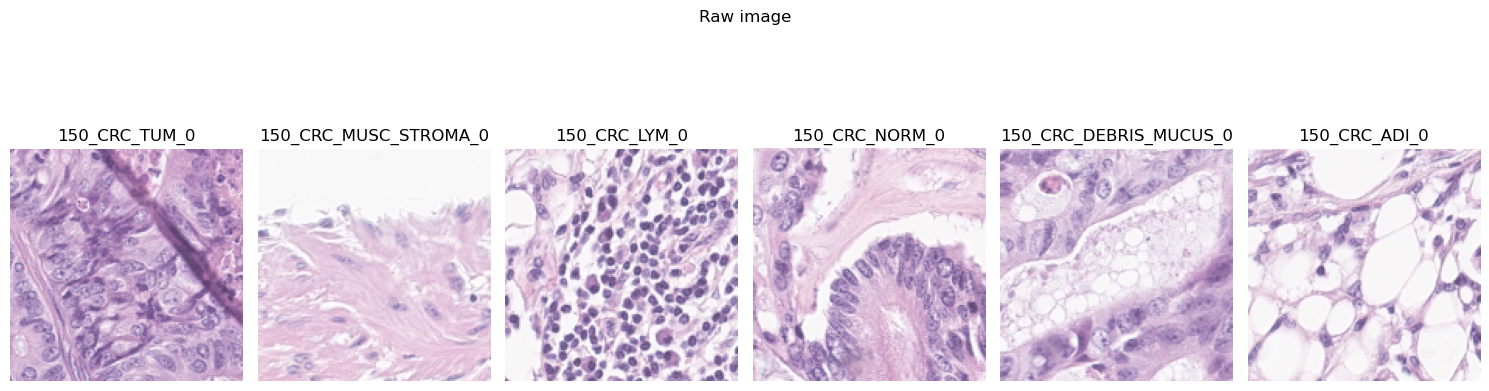

In [4]:
input_path = '../imgs'
image_list, image_name = get_images(input_path)
plot(len(image_name), image_name, image_list, 'Raw image')


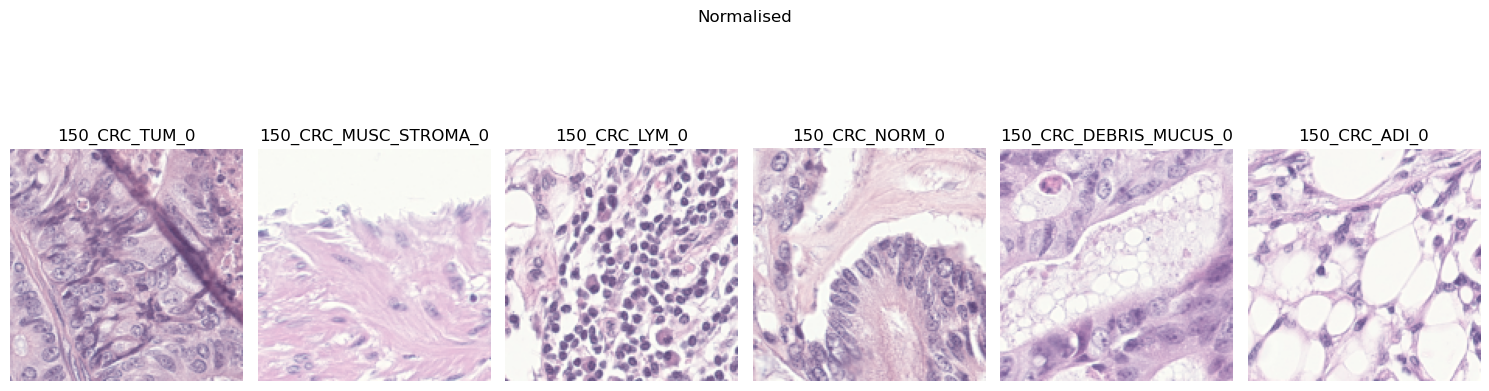

In [5]:

normalized_images = [macenko_normalization(img) for img in image_list]

plot(len(image_name), image_name, normalized_images, 'Normalised')

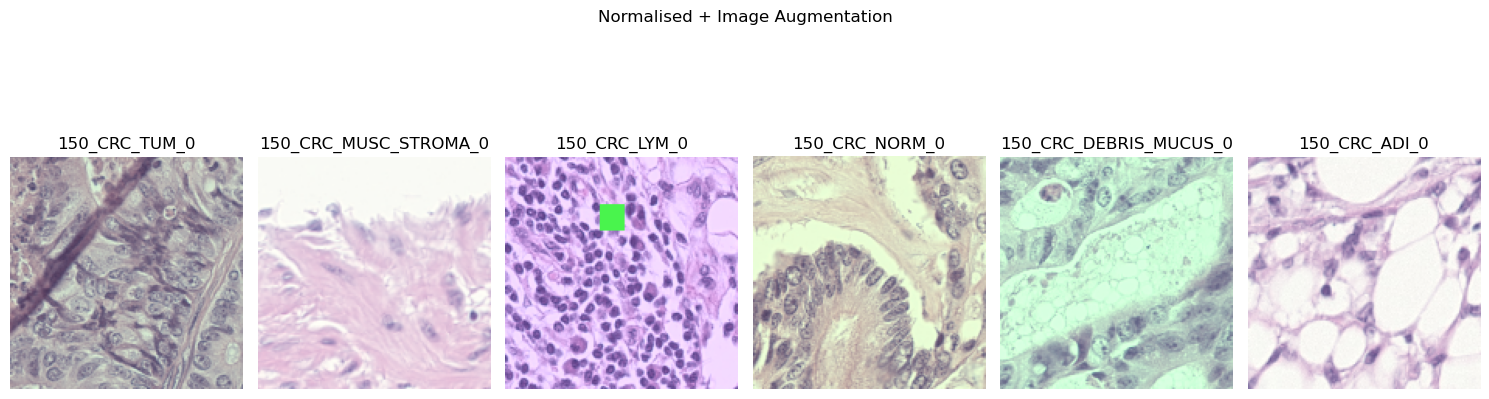

In [6]:

# Define the augmentation pipeline
'''
Attention! Please adjust the probability to 0.1 if shows not as 0.1. Higher probability is just for the test.
'''


# Assume 'images' is a list of your 10 images as numpy arrays

# for subfolder in os.listdir('../imgs'):
# images = [...]  # Your list of images

# Apply the augmentations to all images
augmented_images = ImageAugmentation(normalized_images)

plot(len(image_name), image_name, augmented_images, 'Normalised + Image Augmentation\n')

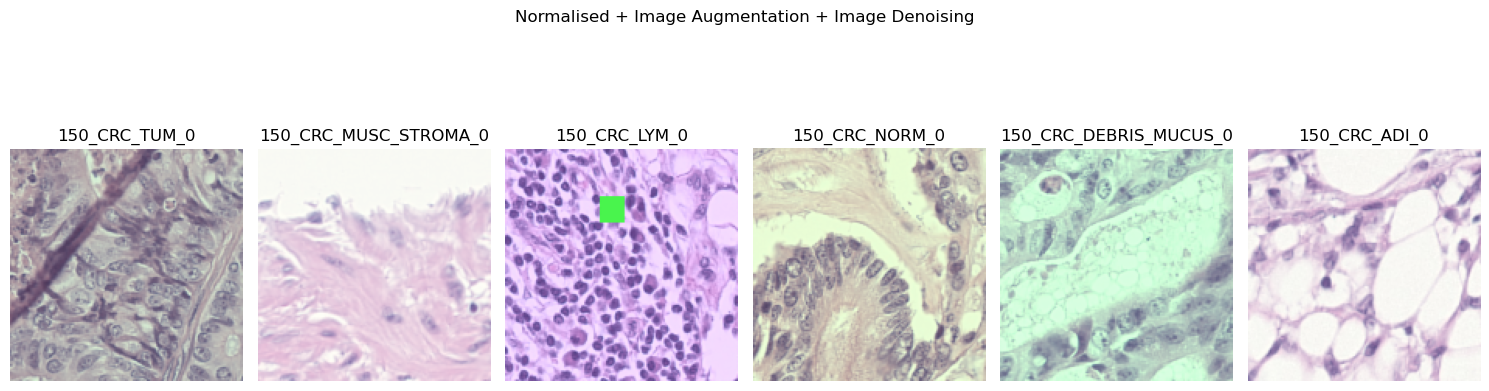

In [7]:
shift_denoised_img = Wavelet_denoising(augmented_images, 3)
# shift_denoised_img = [shift_invariant]

plot(len(image_name), image_name, shift_denoised_img, 'Normalised + Image Augmentation + Image Denoising')